# Analise de influencia das variaveis no churn dos clientes

**Objetivo:** Identificar quais variáveis estão diretamente relacionadas com o churn de clientes, através de métodos como  analise de correlação, regressões múltiplas e análise de sensibilidade. 


## 0. Imports, carga e preparação de dados

In [7]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

As correlações podem ser extraídas diretamente de ferramentas de auto-report, que além de correlações lineares e não lineares nos fornecem uma boa visão geral dos dados.

In [118]:
df = pd.read_csv('../Data/churn.csv')
#profile = ProfileReport(df = df, title = 'churn_eda_report')
categorical_columns = ['gender','Partner','Dependents','PhoneService','MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                    'PaperlessBilling', 'PaymentMethod','Churn']


In [119]:
yes_no_other_columns = categorical_columns[1:12] + [categorical_columns[-3]] + [categorical_columns[-1]]
categorical_columns = list(set(categorical_columns) - set(yes_no_other_columns))
categorical_columns

['PaymentMethod', 'Contract', 'gender']

In [120]:
# Filtrando categorical_columns
categorical_columns = ['PaymentMethod', 'Contract']

In [121]:
for item in yes_no_other_columns:
    print('=='*21)
    print('{}'.format(item))
    print(df[item].unique())
    print('=='*21)

Partner
['Yes' 'No']
Dependents
['No' 'Yes']
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
PaperlessBilling
['Yes' 'No']
Churn
['No' 'Yes']


In [122]:
dict_yes_no_other = {
    'Yes'                   :  1,
    'No'                    :  0, 
    'No internet service'   :  -1,
    'No phone service'      :  -1,
}

df_categorical = df.copy()
dict_categorical_reference = {}

try:
    #Linha de execução única
    yes_no_other_columns.remove('InternetService')
except:
    print('Execute novamente os blocos anteriores')
    pass

# Casos especiais: Internet service, gender, 'PaymentMethod', 'Contract' e InternetService

# PaymentMethod, Contract
for value in categorical_columns:
    for item in df[value].unique():
        df_categorical[value + '_' + item] = df[value].apply(lambda x: 1 if x == item else 0)
    
    # Remove coluna convertida
    df_categorical.drop(columns = value,inplace=True)

# Pre tratamento de InternetService para a conversao
df_categorical[df_categorical['InternetService'] == 'No'] = 0 
print(df_categorical['InternetService'].unique())

# Convertendo InternetService
for item in df_categorical['InternetService'].unique():
    if item != 0:
        df_categorical['InternetService' + '_' + item] = df_categorical['InternetService'].apply(lambda x: 1 if x == item else 0)

df_categorical['InternetService'] = df_categorical['InternetService'].apply(lambda x: 1 if x != 0 else x)


# Gender Male 0, Female 1
df_categorical['gender'] = df['gender'].apply(lambda x: 0 if x == 'Male' else 1)

for item in yes_no_other_columns:
    df_categorical[item] =  df[item].apply(lambda x: dict_yes_no_other[x])

# Ajustando ordem e nome de colunas
df_categorical['CHURN'] = df_categorical['Churn']
df_categorical.drop(columns = 'Churn',inplace=True)
categorical_columns = df_categorical.columns.values
translate_columns = {x : x.replace(' ','_').upper() for x in categorical_columns}
df_categorical.rename(columns = translate_columns,inplace=True)
 


['DSL' 'Fiber optic' 0]


In [108]:
df_categorical.columns

Index(['CUSTOMERID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS',
       'TENURE', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
       'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT',
       'STREAMINGTV', 'STREAMINGMOVIES', 'PAPERLESSBILLING', 'MONTHLYCHARGES',
       'TOTALCHARGES', 'PAYMENTMETHOD_ELECTRONIC_CHECK',
       'PAYMENTMETHOD_MAILED_CHECK', 'PAYMENTMETHOD_BANK_TRANSFER_(AUTOMATIC)',
       'PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC)', 'CONTRACT_MONTH-TO-MONTH',
       'CONTRACT_ONE_YEAR', 'CONTRACT_TWO_YEAR', 'INTERNETSERVICE_DSL',
       'INTERNETSERVICE_FIBER_OPTIC', 'CHURN'],
      dtype='object')

In [109]:
df_categorical.sample(3)

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,...,PAYMENTMETHOD_ELECTRONIC_CHECK,PAYMENTMETHOD_MAILED_CHECK,PAYMENTMETHOD_BANK_TRANSFER_(AUTOMATIC),PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC),CONTRACT_MONTH-TO-MONTH,CONTRACT_ONE_YEAR,CONTRACT_TWO_YEAR,INTERNETSERVICE_DSL,INTERNETSERVICE_FIBER_OPTIC,CHURN
4274,0,0,0,0,0,0,1,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
4774,7402-PWYJJ,1,0,1,0,53,1,1,1,0,...,1,0,0,0,0,1,0,0,1,0
1153,8777-PVYGU,1,0,1,0,52,1,0,1,1,...,0,1,0,0,0,1,0,1,0,0


In [111]:
df_categorical.columns

Index(['CUSTOMERID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS',
       'TENURE', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
       'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT',
       'STREAMINGTV', 'STREAMINGMOVIES', 'PAPERLESSBILLING', 'MONTHLYCHARGES',
       'TOTALCHARGES', 'PAYMENTMETHOD_ELECTRONIC_CHECK',
       'PAYMENTMETHOD_MAILED_CHECK', 'PAYMENTMETHOD_BANK_TRANSFER_(AUTOMATIC)',
       'PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC)', 'CONTRACT_MONTH-TO-MONTH',
       'CONTRACT_ONE_YEAR', 'CONTRACT_TWO_YEAR', 'INTERNETSERVICE_DSL',
       'INTERNETSERVICE_FIBER_OPTIC', 'CHURN'],
      dtype='object')

Verificando os campos numericos em numericos (até então estão tipo object)

In [123]:
for item in df_categorical.columns.values:
    if item not in categorical_columns:
        print('='*30)
        try:
            df_categorical[item] = df_categorical[item].apply(lambda x: float(x))
            print('{} --> Ok'.format(item))
        except Exception as e:
            print('{} -- FALHOU'.format(item))
            print(e)
        print('='*30)

CUSTOMERID -- FALHOU
could not convert string to float: '7590-VHVEG'
GENDER --> Ok
SENIORCITIZEN --> Ok
PARTNER --> Ok
DEPENDENTS --> Ok
TENURE --> Ok
PHONESERVICE --> Ok
MULTIPLELINES --> Ok
INTERNETSERVICE --> Ok
ONLINESECURITY --> Ok
ONLINEBACKUP --> Ok
DEVICEPROTECTION --> Ok
TECHSUPPORT --> Ok
STREAMINGTV --> Ok
STREAMINGMOVIES --> Ok
PAPERLESSBILLING --> Ok
MONTHLYCHARGES --> Ok
TOTALCHARGES -- FALHOU
could not convert string to float: ''
PAYMENTMETHOD_ELECTRONIC_CHECK --> Ok
PAYMENTMETHOD_MAILED_CHECK --> Ok
PAYMENTMETHOD_BANK_TRANSFER_(AUTOMATIC) --> Ok
PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC) --> Ok
CONTRACT_MONTH-TO-MONTH --> Ok
CONTRACT_ONE_YEAR --> Ok
CONTRACT_TWO_YEAR --> Ok
INTERNETSERVICE_DSL --> Ok
INTERNETSERVICE_FIBER_OPTIC --> Ok


In [115]:
df_categorical[df_categorical.TOTALCHARGES == ' '].TENURE.value_counts()

0.0    5
Name: TENURE, dtype: int64

Quando não há vencimentos o totalcharges é nulo

In [125]:
# Adaptando conversão de TotalCharges
df_categorical['TOTALCHARGES'] = df_categorical['TOTALCHARGES'].apply(lambda x: float(x) if x != ' ' else 0)


In [126]:
df_categorical.columns

Index(['CUSTOMERID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS',
       'TENURE', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE',
       'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT',
       'STREAMINGTV', 'STREAMINGMOVIES', 'PAPERLESSBILLING', 'MONTHLYCHARGES',
       'TOTALCHARGES', 'PAYMENTMETHOD_ELECTRONIC_CHECK',
       'PAYMENTMETHOD_MAILED_CHECK', 'PAYMENTMETHOD_BANK_TRANSFER_(AUTOMATIC)',
       'PAYMENTMETHOD_CREDIT_CARD_(AUTOMATIC)', 'CONTRACT_MONTH-TO-MONTH',
       'CONTRACT_ONE_YEAR', 'CONTRACT_TWO_YEAR', 'INTERNETSERVICE_DSL',
       'INTERNETSERVICE_FIBER_OPTIC', 'CHURN'],
      dtype='object')

### 0.2 -  Qualidade dos dados

Aqui serão realizadas algumas verificações de casos impossíveis para validar a qualidade dos dados

#### 0.2.1 Serviços de internet

In [141]:
results = []
internet_testes = ['ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'STREAMINGTV',
                     'STREAMINGMOVIES','INTERNETSERVICE_DSL','INTERNETSERVICE_FIBER_OPTIC']

for item in internet_testes:
    results.append( df_categorical[df_categorical.INTERNETSERVICE == 0][item].value_counts() )
    results.append( df_categorical[df_categorical.INTERNETSERVICE == 1][item].value_counts() )

for item in results:
    print(item)
    print('*'*15)

-1.0    1526
Name: ONLINESECURITY, dtype: int64
***************
0.0    3498
1.0    2019
Name: ONLINESECURITY, dtype: int64
***************
-1.0    1526
Name: ONLINEBACKUP, dtype: int64
***************
0.0    3088
1.0    2429
Name: ONLINEBACKUP, dtype: int64
***************
-1.0    1526
Name: DEVICEPROTECTION, dtype: int64
***************
0.0    3095
1.0    2422
Name: DEVICEPROTECTION, dtype: int64
***************
-1.0    1526
Name: STREAMINGTV, dtype: int64
***************
0.0    2810
1.0    2707
Name: STREAMINGTV, dtype: int64
***************
-1.0    1526
Name: STREAMINGMOVIES, dtype: int64
***************
0.0    2785
1.0    2732
Name: STREAMINGMOVIES, dtype: int64
***************
0.0    1526
Name: INTERNETSERVICE_DSL, dtype: int64
***************
0.0    3096
1.0    2421
Name: INTERNETSERVICE_DSL, dtype: int64
***************
0.0    1526
Name: INTERNETSERVICE_FIBER_OPTIC, dtype: int64
***************
1.0    3096
0.0    2421
Name: INTERNETSERVICE_FIBER_OPTIC, dtype: int64
*************

#### Telefonia

In [142]:
results = []
internet_testes = ['MULTIPLELINES']

for item in internet_testes:
    results.append( df_categorical[df_categorical.PHONESERVICE == 0][item].value_counts() )
    results.append( df_categorical[df_categorical.PHONESERVICE == 1][item].value_counts() )

for item in results:
    print(item)
    print('*'*15)

-1.0    682
Name: MULTIPLELINES, dtype: int64
***************
0.0    3390
1.0    2971
Name: MULTIPLELINES, dtype: int64
***************


## 1. Correlações

In [154]:
a = ['a','b','c']
b = ['a','c','xs','wq']
print(set(a) | set(b))

{'c', 'b', 'xs', 'wq', 'a'}


In [159]:
def filtra_heatmap(p_value_threshold, df_corr):
    
    selected_columns = df_corr[pear_corr['CHURN'] >= p_value_threshold].index.values
    selected_columns_2 = df_corr[pear_corr['CHURN'] <= (p_value_threshold * -1)].index.values
    selected_columns = list(set(selected_columns) | set(selected_columns_2))
    print(selected_columns)
    pear_corr_selected = pear_corr[selected_columns]
    plt.figure(figsize=(16,6))
    sns.heatmap( pear_corr_selected,annot=True)


### 1.1 Linear

['CHURN', 'CONTRACT_MONTH-TO-MONTH', 'INTERNETSERVICE_FIBER_OPTIC', 'PAYMENTMETHOD_ELECTRONIC_CHECK']


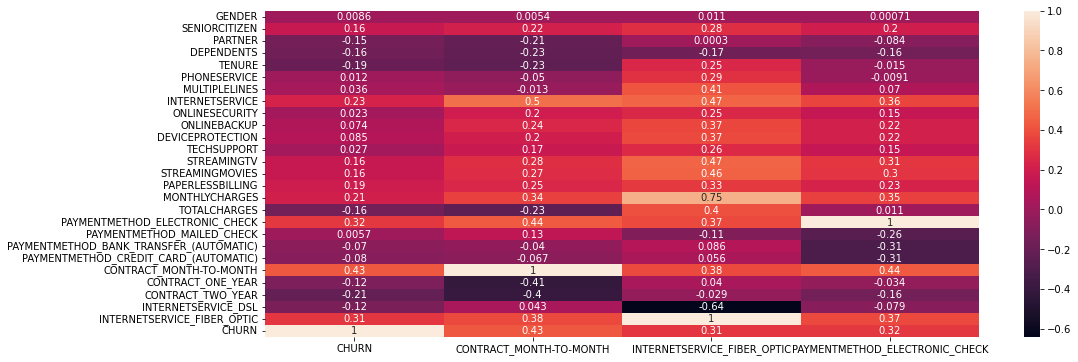

In [161]:
p_value_threshold = 0.3
pear_corr = df_categorical.iloc[:,1:].corr(method='pearson')
filtra_heatmap(p_value_threshold, df_corr=pear_corr)

### 1.2 Não Linear

['CHURN', 'CONTRACT_MONTH-TO-MONTH', 'INTERNETSERVICE_FIBER_OPTIC', 'PAYMENTMETHOD_ELECTRONIC_CHECK']


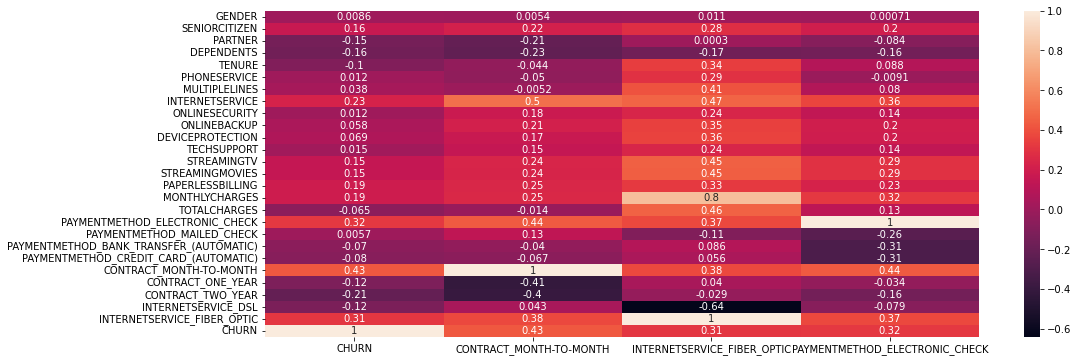

In [163]:
p_value_threshold = 0.3
pear_corr = df_categorical.iloc[:,1:].corr(method='spearman')
filtra_heatmap(p_value_threshold, df_corr=pear_corr)

**Observações:**

O contrato de pagamento mensal possui uma correlação superior ao tipo de serviço contratado, seguido pelo pagamento via electronic check e serviço de fibra

**Existe a possibilidade que apenas uma destas variáveis esteja diretamente relacionada com o churn e as demais sejam consequencias desta primeira, é necessário análises mais aprofundadas para melhores insigths**

## 2. Regressões múltiplas

## 3. Análise de sensibilidade